In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import glob
import struct
import open3d as o3d

from segmentations.segmentation import segmentation_img, human_labeling
from argparse import Namespace
from PCDprocessing.lidar_camera_project import RGB_mapping2pcd, label_coloring2pcd
import argparse
import json
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [15]:
## read json file
def load_config_as_args(json_path):
    """Load configuration from a JSON file and return it as an argparse.Namespace object."""
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"Configuration file not found: {json_path}")
    with open(json_path, 'r') as file:
        config = json.load(file)

    # Convert dictionary to Namespace
    args = Namespace(**config)
    # args = parser.parse_args()
    return args
# args = load_config_as_args("config.json")

## Ipynotebook version
args = argparse.Namespace(
    model='BEiT_ADE',
    pcd_path='./../daeyoung/SemanticKITTI/sequences/07/velodyne/*.bin',
    img2_path='./../daeyoung/SemanticKITTI/sequences/07/image_2/*.png',
    img3_path='./../daeyoung/SemanticKITTI/sequences/07/image_3/*.png',
    lbl_path='./../daeyoung/SemanticKITTI/sequences/07/labels/*.label',
    calib_path='./../daeyoung/SemanticKITTI/sequences/07/calib.txt',
    img_width=1241,
    img_height=376,
    output_path='./../data/outputs/',
    log_path='./path/to/log/files')

point_files = sorted(glob.glob(args.pcd_path))
label_files = sorted(glob.glob(args.lbl_path))
image2_files = sorted(glob.glob(args.img2_path))
image3_files = sorted(glob.glob(args.img3_path))

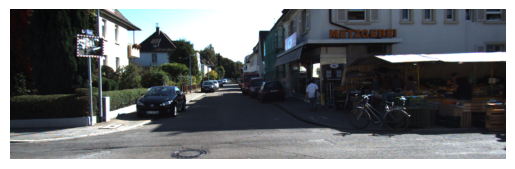

In [ ]:
## Select index and visualize photo
file_index = 1
img2 = image2_files[file_index]
img3 = image3_files[file_index]
binary = point_files[file_index]
label = label_files[file_index]

temp_im = cv2.imread(img2)
temp_im = cv2.cvtColor(temp_im, cv2.COLOR_BGR2RGB)

plt.imshow(temp_im)
plt.axis('off')
plt.show()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmsegmentation/v0.5/beit/upernet_beit-large_fp16_8x1_640x640_160k_ade20k/upernet_beit-large_fp16_8x1_640x640_160k_ade20k-8fc0dd5d.pth


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.9/dist-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/usr/local/lib/python3.9/dist-packages/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


12/17 05:09:33 - mmengine - WARNING - Failed to search registry with scope "mmseg" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmseg" is a correct scope, or whether the registry is initialized.


Output()

/usr/local/lib/python3.9/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


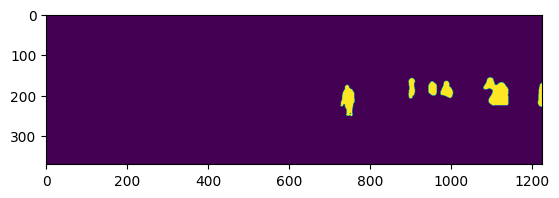

In [14]:
## Segmentation mask generation
human_mask = segmentation_img(img2, args)
plt.imshow(human_mask)
plt.axis('off')
plt.show()

In [ ]:
## Calibration matrix composition
with open(args.calib_path,'r') as f:
    calib = f.readlines()

P2 = np.array([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3, 4)
P3 = np.array([float(x) for x in calib[3].strip('\n').split(' ')[1:]]).reshape(3, 4)
Tr = np.array([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3, 4)
Tr = np.insert(Tr, 3, values=[0, 0, 0, 1], axis=0)

In [80]:
def RGB_mapping2pcd(binary, origin_img, mask_img, P2, Tr, coloring=False, erase=False):
    # read raw data from binary
    scan = np.fromfile(binary, dtype=np.float32).reshape((-1, 4))
    points = scan[:, 0:3]  # lidar xyz (front, left, up)

    # Apply projection matrix
    velo = np.insert(points, 3, 1, axis=1).T
    cam = P2.dot(Tr.dot(velo))
    cam[:2] /= cam[2, :]

    # Preparation on image
    plt.figure(figsize=(12, 5), dpi=96, tight_layout=True)
    if coloring:
        label_color = (255,1,1)
        png = human_labeling(origin_img, mask_img, mask_color=label_color)
    else:
        png = origin_img
    IMG_H, IMG_W, _ = png.shape
    plt.axis([0, IMG_W, IMG_H, 0])

    # Filter point out of canvas
    u, v, z = cam
    u_out = np.logical_or(u < 0, u > IMG_W)
    v_out = np.logical_or(v < 0, v > IMG_H)
    outlier = np.logical_or(u_out, v_out)

    # generate color map from depth
    u, v, z = cam

    # Adding rgb data
    rgb_values = []
    for u_coord, v_coord, z_coord in zip(u, v, z):
        u_int, v_int = int(round(u_coord)), int(round(v_coord))
        if z_coord >= 0:
            if 0 <= u_int < IMG_W and 0 <= v_int < IMG_H:
                rgb_value = png[v_int, u_int]
                rgb_values.append(rgb_value)
            else:
                rgb_values.append((0, 0, 0))
        else:
            rgb_values.append((0, 0, 0))
    
    if coloring:
        ## Erase colored points
        erase_idx = []
        for idx, rgb in enumerate(rgb_values):
            if np.array_equal(rgb,label_color):
                erase_idx.append(idx)
        if erase:
            points = np.delete(points,erase_idx,axis=0)
            rgb_values = np.delete(rgb_values, erase_idx,axis=0)
            rgb_values = np.array(rgb_values)/255.
            u = np.delete(u, erase_idx)
            v = np.delete(v, erase_idx)
    else:
        erase_idx = []
    rgb_values = np.array(rgb_values)/255.
    
    # Create Open3D point cloud
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(rgb_values)

    return point_cloud, (u,v), rgb_values, erase_idx
def label_coloring2pcd(binary, origin_img, P2, Tr, labels, Person_label):
    # read raw data from binary
    scan = np.fromfile(binary, dtype=np.float32).reshape((-1, 4))
    points = scan[:, 0:3]  # lidar xyz (front, left, up)

    # Apply projection matrix
    velo = np.insert(points, 3, 1, axis=1).T
    cam = P2.dot(Tr.dot(velo))
    cam[:2] /= cam[2, :]

    # Preparation on image
    plt.figure(figsize=(12, 5), dpi=96, tight_layout=True)
    label_color = (255,1,1)
    png = origin_img
    IMG_H, IMG_W, _ = png.shape
    plt.axis([0, IMG_W, IMG_H, 0])

    # Filter point out of canvas
    u, v, z = cam
    u_out = np.logical_or(u < 0, u > IMG_W)
    v_out = np.logical_or(v < 0, v > IMG_H)
    outlier = np.logical_or(u_out, v_out)

    # generate color map from depth
    u, v, z = cam

    # Adding rgb data
    rgb_values = []
    for u_coord, v_coord, z_coord in zip(u, v, z):
        u_int, v_int = int(round(u_coord)), int(round(v_coord))
        if z_coord >= 0:
            if 0 <= u_int < IMG_W and 0 <= v_int < IMG_H:
                rgb_value = png[v_int, u_int]
                rgb_values.append(rgb_value)
            else:
                rgb_values.append((0, 0, 0))
        else:
            rgb_values.append((0, 0, 0))
    
    for idx, tmp_lbl in enumerate(labels):
        if tmp_lbl == Person_label:
            rgb_values[idx] = label_color
    rgb_values = np.array(rgb_values)/255.
    
    # Create Open3D point cloud
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(rgb_values)

    return point_cloud, (u,v), rgb_values

# o3d.io.write_point_cloud("./../data/outputs/projected_erased.pcd", point_cloud)

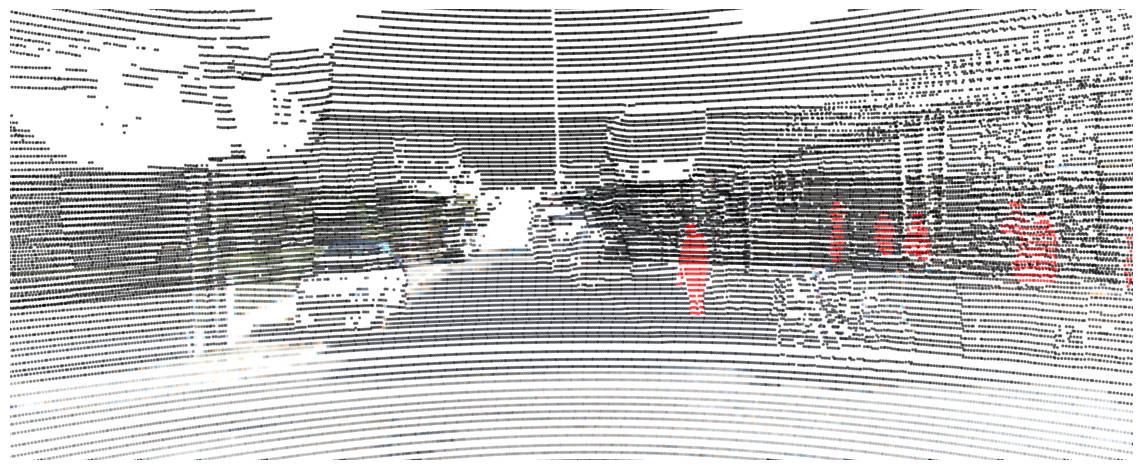

In [ ]:
## Select index and visualize photo
file_index = 1
Person_label = 30
img = image2_files[file_index]
binary = point_files[file_index]
label = label_files[file_index]

origin_img = cv2.imread(img)
origin_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)
PCD_output, PCD_UV, PCD_rgb, PCD_erase_idx = RGB_mapping2pcd(binary, 
                                                            origin_img, 
                                                            human_mask, 
                                                            P2, Tr, coloring=True, erase=False)
plt.scatter([PCD_UV[0]],[PCD_UV[1]], c=PCD_rgb, alpha=0.5, s=2)
plt.axis('off')
plt.show()

In [83]:
Person_label = 30
lbls = np.fromfile(label, dtype=np.uint32) & 0xFFFF
num = 0
for idx in PCD_erase_idx:
    if lbls[idx]==Person_label:
        num+=1
num2 = 0
for nums in lbls:
    if nums==Person_label:
        num2+=1
print(num, num2, len(PCD_erase_idx))


[ 0  0  0 ... 40 40 40]


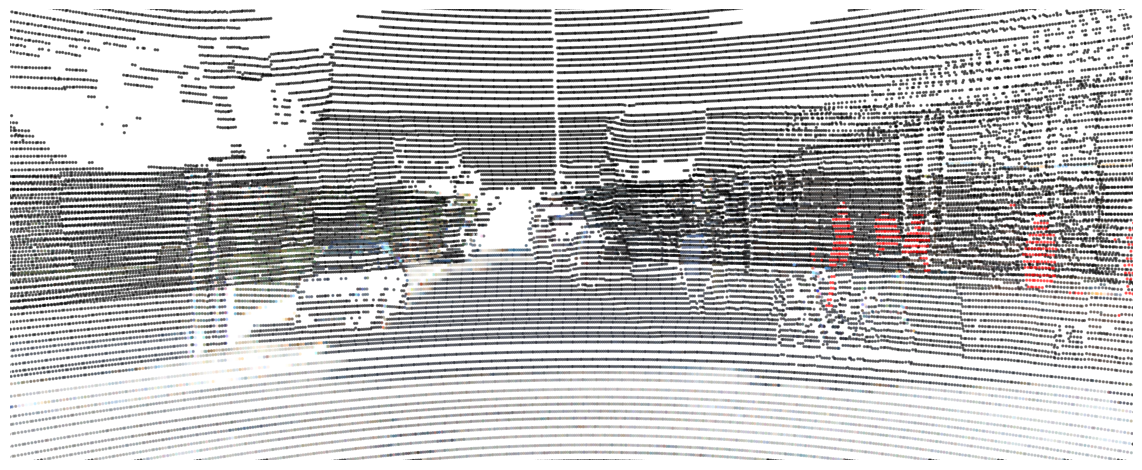

In [88]:
origin_img = cv2.imread(img)
origin_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)

lbl_PCD, lbl_UV, lbl_rgb = label_coloring2pcd(binary, 
                                            origin_img,
                                            P2, Tr, lbls, Person_label)

o3d.io.write_point_cloud("./../data/outputs/label_PCD.pcd", lbl_PCD)
plt.scatter([lbl_UV[0]],[lbl_UV[1]], c=lbl_rgb, alpha=0.5, s=2)
plt.axis('off')
plt.show()